# Naive

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import Naive
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/naive.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

## Evaluation metrics definition

In [8]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [9]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [10]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = Naive(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:03<00:00, 127.45it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 112.2000
	Loss_MB/train_phase/train_stream/Task000 = 1.0798
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6800
100%|██████████| 469/469 [00:03<00:00, 129.42it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 112.7000
	Loss_MB/train_phase/train_stream/Task000 = 0.6965
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6238
100%|██████████| 469/469 [00:03<00:00, 129.16it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 113.0000
	Loss_MB/train_phase/train_stream/Task000 = 0.5934
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 3.6313
100%|██████████| 469/469 [00:03<00:00, 128.78it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 10%|█         | 1/10 [00:27<04:06, 27.40s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.6541
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16700a220>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 20%|██        | 2/10 [00:54<03:36, 27.03s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.3311
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x169d3ab80>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.8950, 0.9267, 0.0986, 0.0986, 0.1610, 0.0782, 0.0943, 0.0827, 0.1154,
         0.1797],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 30%|███       | 3/10 [01:20<03:07, 26.73s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 106.3401
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17d35fd60>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.8950, 0.9267, 0.0986, 0.0986, 0.1610, 0.0782, 0.0943, 0.0827, 0.1154,
         0.1797],
        [0.8775, 0.8955, 0.9333, 0.0883, 0.1318, 0.0952, 0.0664, 0.1030, 0.1078,
         0.1620],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 40%|████      | 4/10 [01:49<02:45, 27.58s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7853
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17d6717f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.8950, 0.9267, 0.0986, 0.0986, 0.1610, 0.0782, 0.0943, 0.0827, 0.1154,
         0.1797],
        [0.8775, 0.8955, 0.9333, 0.0883, 0.1318, 0.0952, 0.0664, 0.1030, 0.1078,
         0.1620],
        [0.8126, 0.8680, 0.9119, 0.9351, 0.1059, 0.0696, 0.0757, 0.1063, 0.1003,
         0.1440],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 50%|█████     | 5/10 [02:17<02:18, 27.73s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6317
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17dd286d0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.8950, 0.9267, 0.0986, 0.0986, 0.1610, 0.0782, 0.0943, 0.0827, 0.1154,
         0.1797],
        [0.8775, 0.8955, 0.9333, 0.0883, 0.1318, 0.0952, 0.0664, 0.1030, 0.1078,
         0.1620],
        [0.8126, 0.8680, 0.9119, 0.9351, 0.1059, 0.0696, 0.0757, 0.1063, 0.1003,
         0.1440],
        [0.8034, 0.8366, 0.8969, 0.9013, 0.9374, 0.0874, 0.0675, 0.1054, 0.1456,
         0.1685],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 60%|██████    | 6/10 [02:44<01:50, 27.61s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7231
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17de64070>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.8950, 0.9267, 0.0986, 0.0986, 0.1610, 0.0782, 0.0943, 0.0827, 0.1154,
         0.1797],
        [0.8775, 0.8955, 0.9333, 0.0883, 0.1318, 0.0952, 0.0664, 0.1030, 0.1078,
         0.1620],
        [0.8126, 0.8680, 0.9119, 0.9351, 0.1059, 0.0696, 0.0757, 0.1063, 0.1003,
         0.1440],
        [0.8034, 0.8366, 0.8969, 0.9013, 0.9374, 0.0874, 0.0675, 0.1054, 0.1456,
         0.1685],
        [0.7021, 0.7998, 0.8838, 0.8995, 0.9198, 0.9396, 0.0839, 0.1384, 0.1195,
         0.1237],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 70%|███████   | 7/10 [03:13<01:23, 27.99s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.6315
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17e9ce430>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.8950, 0.9267, 0.0986, 0.0986, 0.1610, 0.0782, 0.0943, 0.0827, 0.1154,
         0.1797],
        [0.8775, 0.8955, 0.9333, 0.0883, 0.1318, 0.0952, 0.0664, 0.1030, 0.1078,
         0.1620],
        [0.8126, 0.8680, 0.9119, 0.9351, 0.1059, 0.0696, 0.0757, 0.1063, 0.1003,
         0.1440],
        [0.8034, 0.8366, 0.8969, 0.9013, 0.9374, 0.0874, 0.0675, 0.1054, 0.1456,
         0.1685],
        [0.7021, 0.7998, 0.8838, 0.8995, 0.9198, 0.9396, 0.0839, 0.1384, 0.1195,
         0.1237],
        [0.6751, 0.7271, 0.8411, 0.8792, 0.8868, 0.9202, 0.9393, 0.1192, 0.1222,
         0.1497],
    

 80%|████████  | 8/10 [03:42<00:56, 28.16s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4232
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17eef6fd0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.8950, 0.9267, 0.0986, 0.0986, 0.1610, 0.0782, 0.0943, 0.0827, 0.1154,
         0.1797],
        [0.8775, 0.8955, 0.9333, 0.0883, 0.1318, 0.0952, 0.0664, 0.1030, 0.1078,
         0.1620],
        [0.8126, 0.8680, 0.9119, 0.9351, 0.1059, 0.0696, 0.0757, 0.1063, 0.1003,
         0.1440],
        [0.8034, 0.8366, 0.8969, 0.9013, 0.9374, 0.0874, 0.0675, 0.1054, 0.1456,
         0.1685],
        [0.7021, 0.7998, 0.8838, 0.8995, 0.9198, 0.9396, 0.0839, 0.1384, 0.1195,
         0.1237],
        [0.6751, 0.7271, 0.8411, 0.8792, 0.8868, 0.9202, 0.9393, 0.1192, 0.1222,
         0.1497],
    

 90%|█████████ | 9/10 [04:10<00:28, 28.38s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7352
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17f214a30>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.8950, 0.9267, 0.0986, 0.0986, 0.1610, 0.0782, 0.0943, 0.0827, 0.1154,
         0.1797],
        [0.8775, 0.8955, 0.9333, 0.0883, 0.1318, 0.0952, 0.0664, 0.1030, 0.1078,
         0.1620],
        [0.8126, 0.8680, 0.9119, 0.9351, 0.1059, 0.0696, 0.0757, 0.1063, 0.1003,
         0.1440],
        [0.8034, 0.8366, 0.8969, 0.9013, 0.9374, 0.0874, 0.0675, 0.1054, 0.1456,
         0.1685],
        [0.7021, 0.7998, 0.8838, 0.8995, 0.9198, 0.9396, 0.0839, 0.1384, 0.1195,
         0.1237],
        [0.6751, 0.7271, 0.8411, 0.8792, 0.8868, 0.9202, 0.9393, 0.1192, 0.1222,
         0.1497],
    

100%|██████████| 10/10 [04:39<00:00, 27.99s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3776
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x17f49ce80>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 2255.5615
	EvalStream/Acc_Matrix = 
tensor([[0.9127, 0.1655, 0.0983, 0.1198, 0.1317, 0.0938, 0.0940, 0.1013, 0.1250,
         0.1599],
        [0.8950, 0.9267, 0.0986, 0.0986, 0.1610, 0.0782, 0.0943, 0.0827, 0.1154,
         0.1797],
        [0.8775, 0.8955, 0.9333, 0.0883, 0.1318, 0.0952, 0.0664, 0.1030, 0.1078,
         0.1620],
        [0.8126, 0.8680, 0.9119, 0.9351, 0.1059, 0.0696, 0.0757, 0.1063, 0.1003,
         0.1440],
        [0.8034, 0.8366, 0.8969, 0.9013, 0.9374, 0.0874, 0.0675, 0.1054, 0.1456,
         0.1685],
        [0.7021, 0.7998, 0.8838, 0.8995, 0.9198, 0.9396, 0.0839, 0.1384, 0.1195,
         0.1237],
        [0.6751, 0.7271, 0.8411, 0.8792, 0.8868, 0.9202, 0.9393, 0.1192, 0.1222,
         0.1497],
    

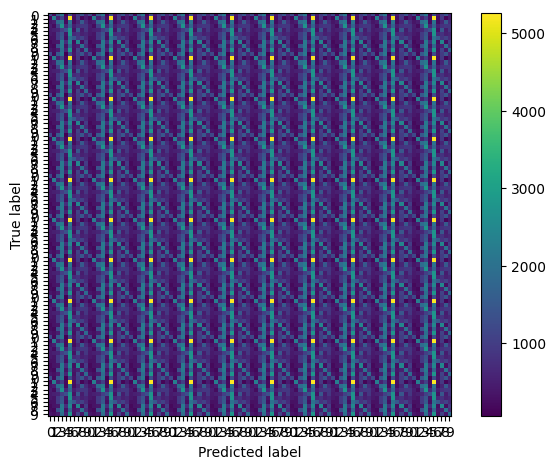

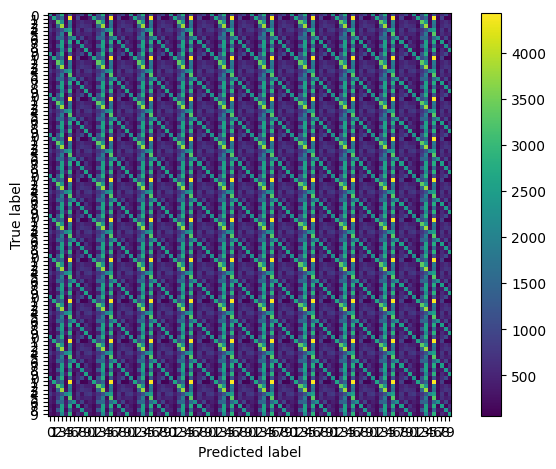

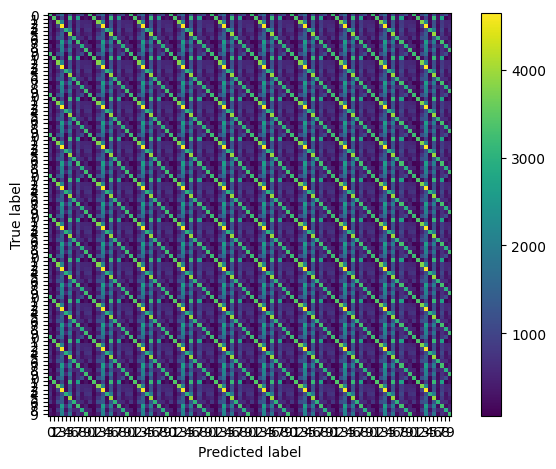

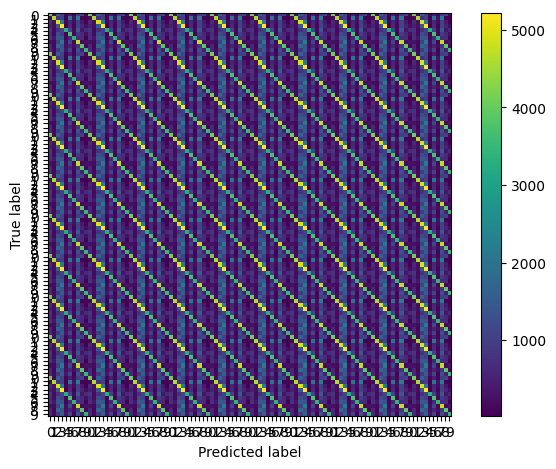

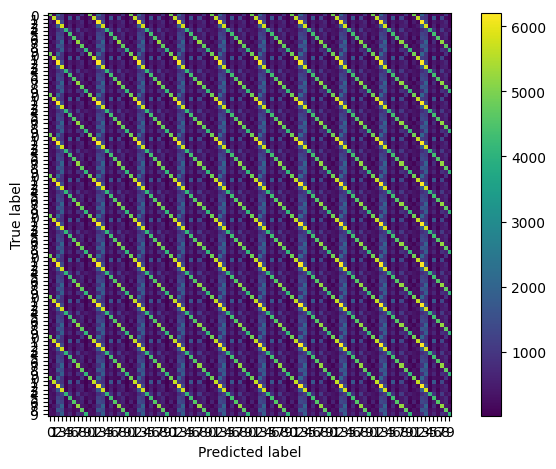

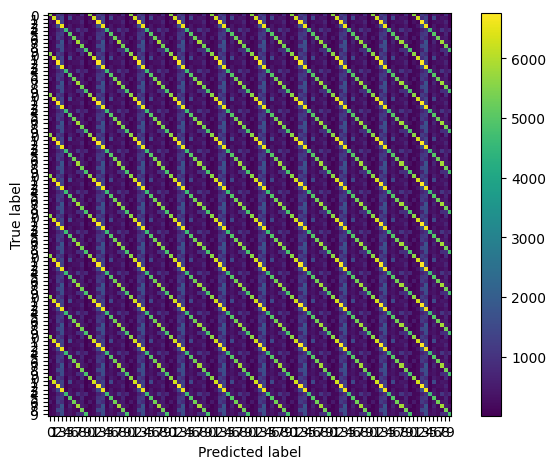

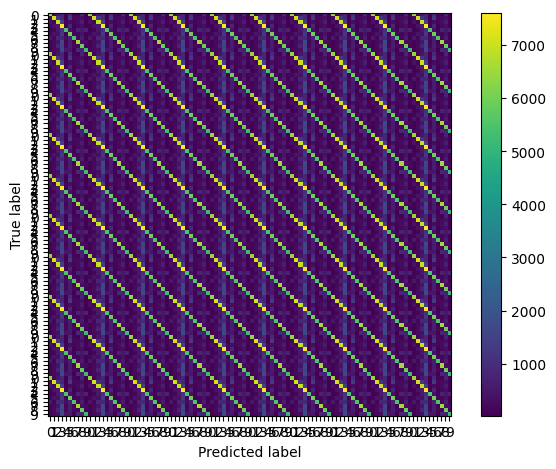

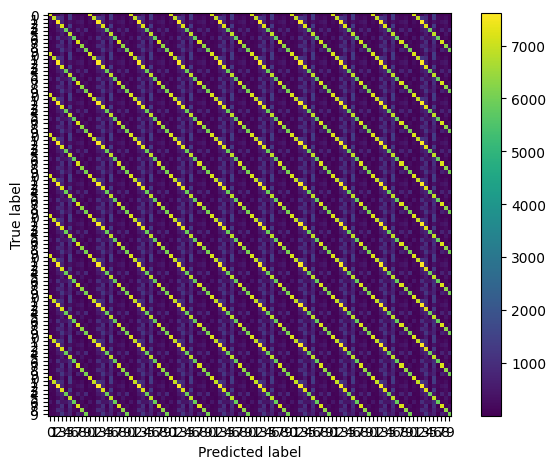

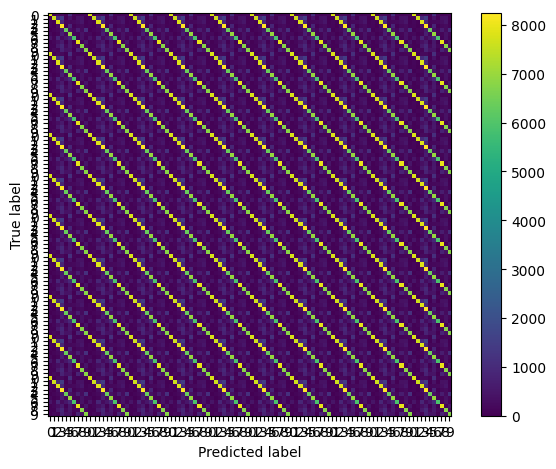

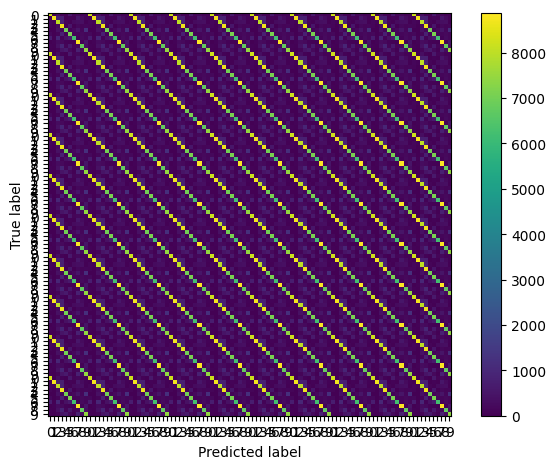

In [11]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [12]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [13]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [14]:
weights = model_plugins[0].weights

# Store metrics

In [15]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))